# Project 5: Ballistic Vehicle Altimetry System Design
>**Date Created**: 8 April 2024<br>
>**Course**: AEM556 - Optimal Estimation<br>
>**Author**: Benjamin Lucke<br>

In [389]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sympy as sp
from scipy.integrate import odeint
from scipy.linalg import cholesky
import os

plt.rcParams["text.usetex"] = False
plt.rcParams["legend.edgecolor"] = "black"

In [390]:
data = 'altimeter_data.csv'
df = pd.read_csv(data,header=None, names=['t','yk','hk','sk','cbk'])

In [391]:
# Create symbolic representations of variables to compute jacobians using SymPy
h, s, d, delt, cb, rn, hr, hn, re, gn = sp.symbols(r'h s d \Delta{t} C_b \rho_0 h_\rho h_0 R_E g_0') 

# A. Implement an extended Kalman filter (EKF) to estimate the vehicle states, $h$ and $s$, and the ballistic coefficient parameter, $C_b$.

### Dynamics Model

In [392]:
def propogate(x):
    '''Function to propogate full nonlinear dynamics with euler (first order) integration'''
    dt = 0.5
    rho_0 = .0765
    g0 = 32.2
    h_rho = 30000
    Re = 20902260
    h = x[0]
    s = x[1]
    cb = x[2]

    hkp1 = h + dt*s
    skp1 = s + dt*(((rho_0*s**2)/(2*cb)*np.exp(-h/h_rho)) - (g0*((Re/(Re+h))**2)))
    cbkp1 = cb
    return np.array([hkp1, skp1, cbkp1])

In [393]:
def jacobian_F(x):
    '''Function that computes analytical jacobian of F at state x'''
    F_discrete_symbolic = sp.Matrix([[h + delt*s],
                                [s + (delt*(((rn*s**2)/(2*cb)*sp.exp(-h/hr)) - (gn*((re/(re+h))**2))))],
                                [cb]])
    constants_mapper = dict(zip([delt,rn,gn,hr,re],[.5, .0765, 32.2, 30000, 20902260])) # Use given constant values to map to symbolic 
    F_jacobian_symbolic = F_discrete_symbolic.jacobian([h, s, cb]).subs(constants_mapper) # take jacobian and substitute in numerical values
    
    x = (np.array(x)).flatten()
    h_in = x[0]
    s_in = x[1]
    cb_in = x[2]
    F_jacobian = F_jacobian_symbolic.subs({h:h_in, s:s_in, cb:cb_in})
    return np.array(F_jacobian).astype(np.float64)

### Measurement Model

In [394]:
def get_measurement(x):
    '''Computes predicted measurement using nonlinear measurement model'''
    h_in = x[0]
    d = 100000
    out = np.sqrt(d**2 + h_in**2)
    return out

In [395]:
def jacobian_H(x):
    h_in = x[0]
    s_in = x[1]
    cb_in = x[2]
    measurement_function = sp.Matrix([sp.sqrt(d**2 + h**2)])
    jacobian_H = measurement_function.jacobian([h, s, cb]).subs({h:h_in, s:s_in, d:100000})
    return np.array(jacobian_H).astype(np.float64).flatten()

### Filter Equations

In [396]:
def predict(x_in, P_in, Q):
    F_jacobian = jacobian_F(x_in)
    x_k_km1 = propogate(x_in)
    P_k_km1 = F_jacobian @ P_in @ F_jacobian.T + Q
    return x_k_km1, P_k_km1

def update(x_k_km1, P_k_km1, range_meas):
    predicted_meausurement = get_measurement(x_k_km1) # Use measurement model h(x) to get predicted meas. based on dynamics
    y_tilde = predicted_meausurement - range_meas 
    Hk = jacobian_H(x_k_km1)
    Sk = (Hk @ P_k_km1 @ Hk.T) + R
    Kk = (P_k_km1 @ Hk.T)/Sk
    x_k_k = x_k_km1 - np.dot(Kk, y_tilde)
    Krk = Kk.reshape(3,1) @ R.reshape(1,1) @ Kk.reshape(1,3)
    imkh = np.eye(3) - (Kk.reshape(3,1) @ Hk.reshape(1,3))
    P_k_k = imkh @ P_k_km1 @ imkh.T
    return x_k_k, P_k_k

### Run Filter on Measurements

In [397]:
P0 = np.diag([100**2, 10**2, 1])
Q = np.diag([10**2, 10**2, .05**2])
R = np.array([100**2])
x0 = np.array([400000, -2000, 20])

n = len(df['yk'])
res = np.zeros((n, 3))
Pks = np.zeros((n, 3, 3))
measurements_vector = df['yk'].to_numpy()
for k in range(n):
    if k == 0:
        x = x0
        P = P0
        res[k] = x
        Pks[k] = P
        continue
    x_k_k1, P_k_k1 = predict(x, P, Q)
    x_k_k, P_k_k = update(x_k_k1, P_k_k1, measurements_vector[k])
    x = x_k_k
    P = P_k_k
    res[k] = x
    Pks[k] = P

Text(0, 0.5, 'Ballistic Coefficient (ft/s)')

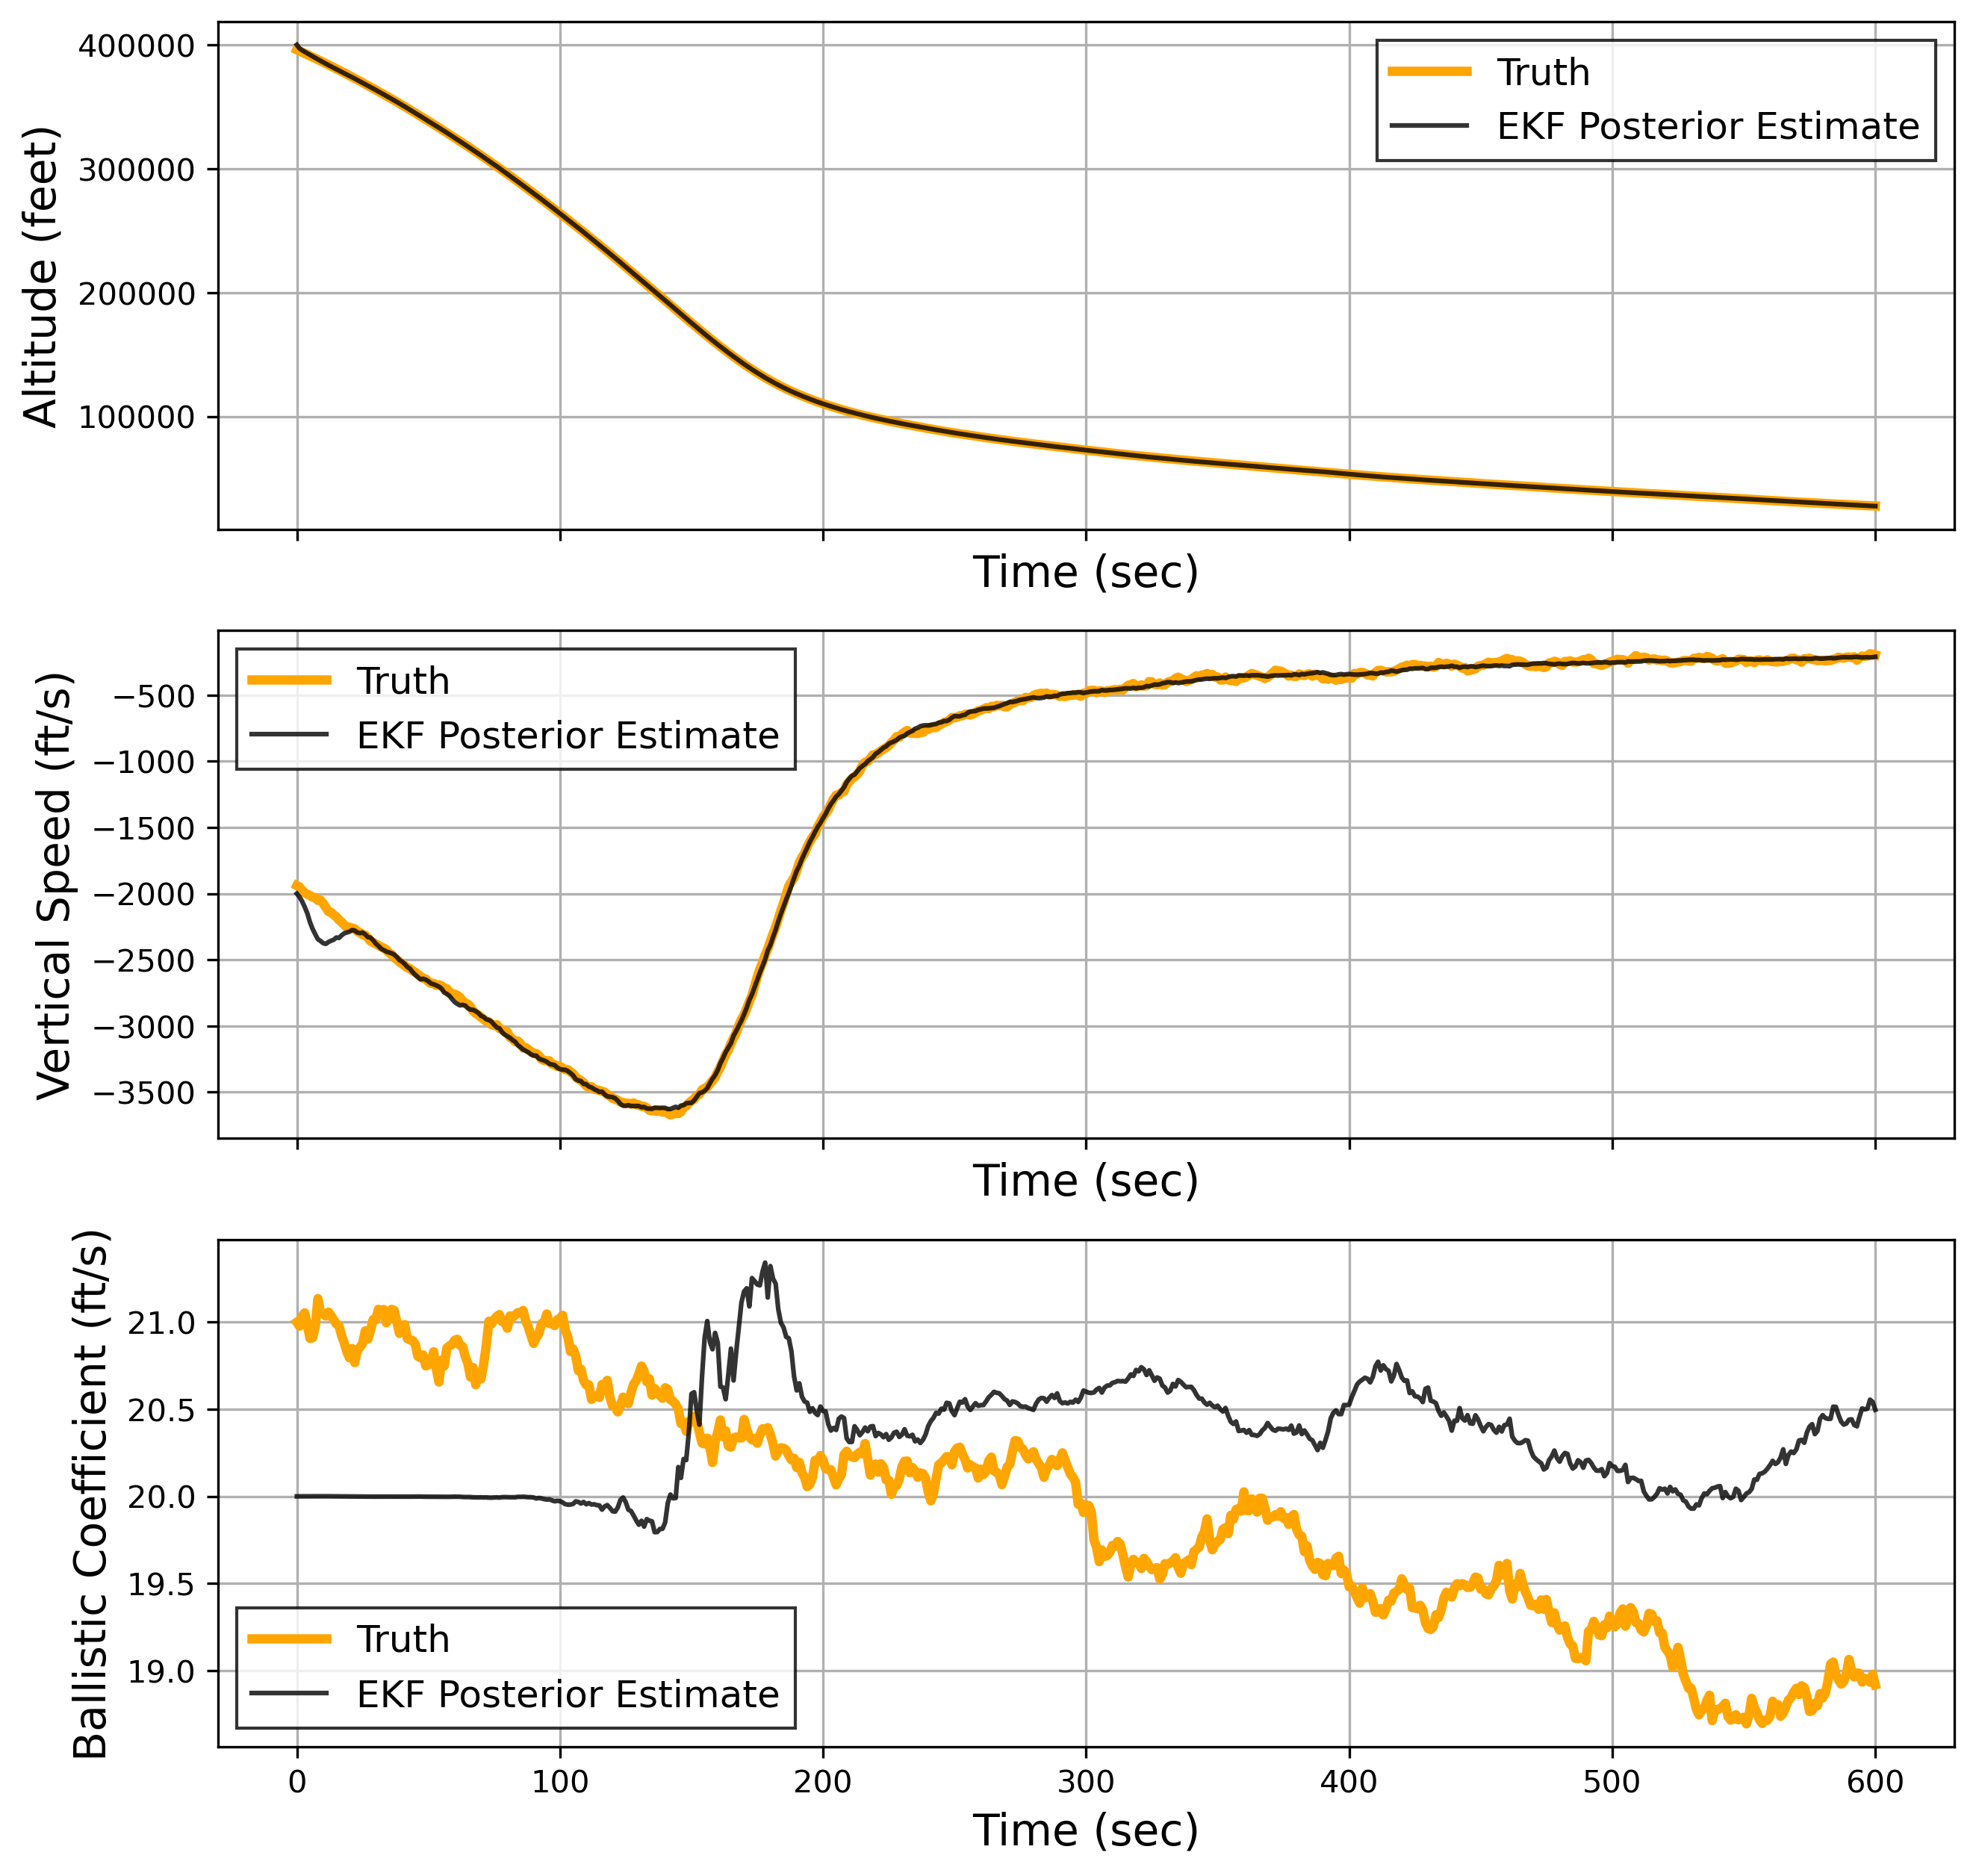

In [398]:
fig,(ax1, ax2, ax3) = plt.subplots(dpi=300,figsize=(10,10),nrows=3,ncols=1, sharex=True)
ax1.plot(df['hk'],c='orange',linestyle='-',lw=3,label='Truth')
ax1.plot(res[:,0],c='black',linestyle='-',alpha=0.8,label='EKF Posterior Estimate')
ax1.grid()
leg = ax1.legend(fancybox=False,fontsize=12)
ax1.set_xlabel('Time (sec)',fontsize=14)
ax1.set_ylabel('Altitude (feet)',fontsize=14)

ax2.plot(df['sk'],c='orange',linestyle='-',lw=3,label='Truth')
ax2.plot(res[:,1],c='black',linestyle='-',alpha=0.8,label='EKF Posterior Estimate')
ax2.grid()
leg = ax2.legend(fancybox=False,fontsize=12)
ax2.set_xlabel('Time (sec)',fontsize=14)
ax2.set_ylabel('Vertical Speed (ft/s)',fontsize=14)

ax3.plot(df['cbk'],c='orange',linestyle='-',lw=3,label='Truth')
ax3.plot(res[:,2],c='black',linestyle='-',alpha=0.8,label='EKF Posterior Estimate')
ax3.grid()
leg = ax3.legend(fancybox=False,fontsize=12)
ax3.set_xlabel('Time (sec)',fontsize=14)
ax3.set_ylabel('Ballistic Coefficient (ft/s)',fontsize=14)

# B. Implement a sigma-point Kalman filter (SPKF), e.g., an unscented Kalman filter (UKF), to estimate the vehicle states, $h$ and $s$, and the ballistic coefficient parameter, $C_b$.

### Define functions to compute unscented transform 

In [427]:
def getlam(alfa=.5, L=3, k = 0):
    return alfa**2 + (L + k) - L
    
def compute_sigmas(X, P, Q, alpha = .1):
    '''Algorithm for selecting sigma points from https://groups.seas.harvard.edu/courses/cs281/papers/unscented.pdf'''
    L = len(X)
    lam = getlam(alfa=alpha, L=L, k = 0, beta = 2)
    
    # Allocate array to hold 2L+1 sigma points
    sigpts = np.zeros((2*L+1, L)) 
    
    # square root of matrix can be found using cholesky decmposition, Sigma = S*S.T implies S is square root of Sigma 
    sqrt_P = cholesky((L +lam)*P + Q)
    sigpts[0] = X
    
    for k in range(L):
        sigpts[k+1] = sigpts[0] + sqrt_P[k] # for points i = 1 ... L make on positive side of mean
        sigpts[L+k+1] = sigpts[0] - sqrt_P[k]  # for points i = (L+1) ... 2*L make on negative side of mean
    return sigpts 
        
def get_weights(X, alpha=1e-3, beta = 2):
    L = len(X)
    lam = getlam(alfa=alpha, L=L, k = 0)

    # Compute weights for means
    weights_m = np.zeros(2*L + 1)
    weights_c = np.zeros(2*L + 1)

    weights_m[0] = lam/(L + lam)
    weights_c[0] = (lam/(L + lam)) + (1 - alpha**2 + beta)
    
    for k in range(2*L):
        weights_m[k+1] = 1/(2*(L + lam))
        weights_c[k+1] = 1/(2*(L + lam))
        
    return weights_m, weights_c

In [524]:
def unscented_transform(X, P, Q, alpha=1e-3, beta = 2, k = 0):
    L = len(X)
    lamda = alpha**2 + (L + k) - L
    
    # Define arrays to hold sigma points and weights
    sigs, wc, wm = np.zeros((2*L+1, L)), np.zeros(2*L + 1), np.zeros(2*L + 1)
    
    # Get sigma points
    U = cholesky((L + lamda)*(P + Q)) # L + lambda*P is a matrix, find its
    sigs[0] = X
    for k in range(L):
        sigs[k+1] = sigs[0] + U[k] # for points i = 1 ... L make on positive side of mean
        sigs[L+k+1] = sigs[0] - U[k]  # for points i = (L+1) ... 2*L make on negative side of mean
        
    # Get weights 
    wm[0] = lamda/(L + lamda)
    wc[0] = (lamda/(L + lamda)) + (1 - alpha**2 + beta)
    for k in range(2*L):
        wm[k+1] = 1/(2*(L + lamda))
        wc[k+1] = 1/(2*(L + lamda))
    return sigs, wm, wc 

    

In [525]:
spts = compute_sigmas(x0, P0, Q).T
wm, wc = get_weights(x0)
res = propogate(spts).T
xbar = np.dot(wm, res)

In [538]:
s, wmm, wcc = unscented_transform(x0, P0, Q)
ress = propogate(s.T)
xbarr = np.dot(wmm, ress.T)